In [138]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [139]:
# layer norm
# i wanna see if the transformer can generalize on an "obvious" task btr if i override layernorm

In [156]:
class my_transformer(nn.Module):
    def __init__(self, embed_d=64):
        super().__init__()
        self.embed = nn.Linear(1,embed_d)
        self.layer = nn.TransformerEncoderLayer(embed_d,1, activation="relu", batch_first=True)
        self.transform = nn.TransformerEncoder(self.layer,1)
     #  self.layer.norm1 = nn.Identity()
#       self.layer.norm2 = nn.Identity()
        self.unembed = nn.Linear(embed_d,1)

    def forward(self, x):
        x = self.embed(x)
        x= self.transform(x)
        x= self.unembed(x)
        return x

In [157]:
x = torch.linspace(-10,10,100).unsqueeze(1).unsqueeze(1)

y = torch.sin(x)

x_train = x
y_train = y

#x_val = x[70:]
#y_val = y[70:]

train_dataset = torch.utils.data.TensorDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=len(x))
#val_dataset = torch.utils.data.TensorDataset(x_val,y_val)
#val_loader = torch.utils.data.DataLoader(val_dataset)

the_model = my_transformer()

optim = torch.optim.AdamW(the_model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

/opt/anaconda3/envs/MI_research/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


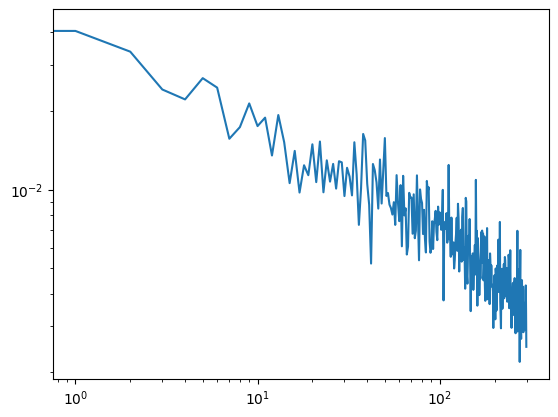

In [161]:
loss_list=[]

the_model.train()
for epochs in range(30000):
    
    losss=0
    for X_batch, Y_batch in train_loader:
        output = the_model(X_batch)
        loss = loss_fn(output,Y_batch)
        loss.backward()
        optim.step()
        losss+= loss
        optim.zero_grad()
    
    if epochs%100==0:
       # print(losss)
        loss_list.append(loss.detach())


plt.plot(loss_list)  
plt.xscale("log")
plt.yscale("log")
plt.show()  
    

In [162]:
plt.show()

torch.Size([40])


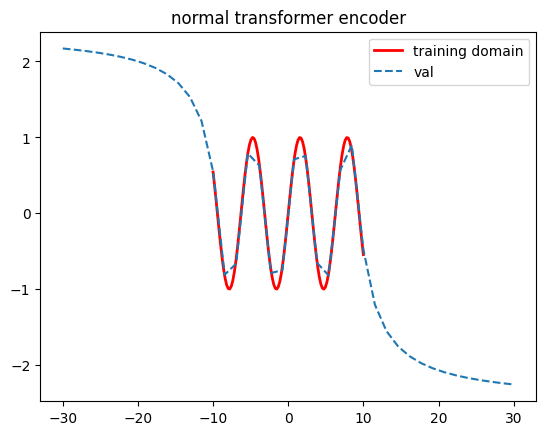

my_transformer(
  (embed): Linear(in_features=1, out_features=64, bias=True)
  (layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transform): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Drop

torch.Size([100, 1, 1])

In [163]:
#title stuff
if isinstance(the_model.layer.norm1, nn.Identity):
    title = "transformer, no layernorm"
else:
    title= "transformer, same but with layernorm"



the_model.eval()
thing_to_test_on = torch.linspace(-30,30, 40)
print(thing_to_test_on.shape)
plt.plot(x.squeeze(),y.squeeze(),c="red", linewidth="2", label="training domain")
#plt.plot(x.squeeze(), the_model(x).squeeze().detach(), linestyle="dashed", label="val"  )

plt.plot(thing_to_test_on.squeeze(), the_model(thing_to_test_on.unsqueeze(1).unsqueeze(1)).squeeze().detach(), linestyle="dashed", label="val"  )
plt.title("normal transformer encoder")
plt.legend()
plt.show()

print(the_model)

x.shape

In [145]:
# ok im weirded out by the transformer plataeuing outside training domain. maybe its due to layernorm. 
#lets just build my own simple transformer to see if we get different behavior

class Karl_Transformer(nn.Module):
    def __init__(self, input_d=1,output_d=1,hidden_d=16):
        super().__init__()
        self.embed = nn.Linear(input_d,hidden_d)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_d,num_heads=1, batch_first=True)
        self.ffn = nn.Sequential(nn.Linear(hidden_d,4*hidden_d), nn.ReLU(), nn.Linear(4*hidden_d, hidden_d))
        self.unembed = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        x = self.embed(x)
        x = x + self.attn(x,x,x)[0] #turns out nn.MultiheadAttention results results, weights
        x = x + self.ffn(x)
        x = self.unembed(x)
        return x

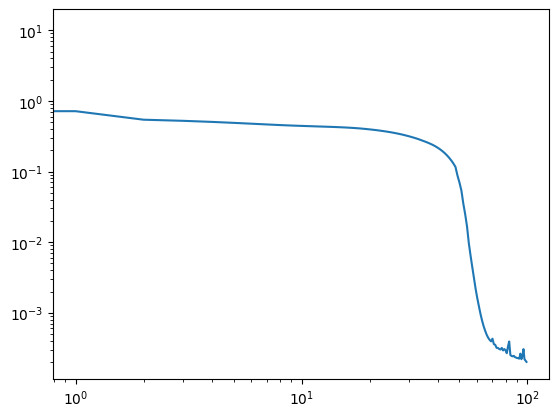

In [146]:
new_transformer = Karl_Transformer()

optim = torch.optim.AdamW(new_transformer.parameters(), lr=1e-4)

loss_list=[]

the_model.train()
for epochs in range(10000):
    
    losss=0
    for X_batch, Y_batch in train_loader:
        output = new_transformer(X_batch)
        loss = loss_fn(output,Y_batch)
        loss.backward()
        optim.step()
        losss+= loss
        optim.zero_grad()
    
    if epochs%100==0:
       # print(losss)
        loss_list.append(loss.detach())


plt.plot(loss_list)  
plt.xscale("log")
plt.yscale("log")
plt.show()  
    

torch.Size([40])


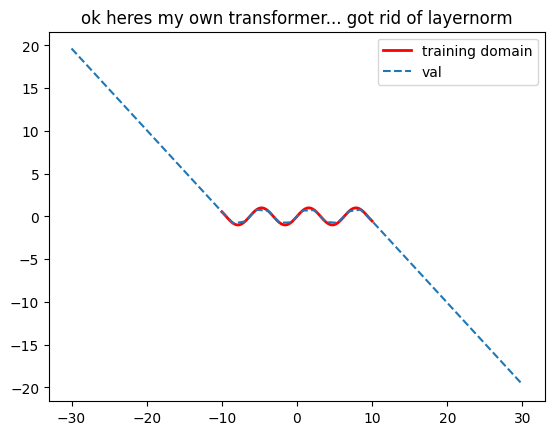

my_transformer(
  (embed): Linear(in_features=1, out_features=16, bias=True)
  (layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (linear1): Linear(in_features=16, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=16, bias=True)
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transform): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (linear1): Linear(in_features=16, out_features=2048, bias=True)
        (dropout): Drop

In [147]:
the_model.eval()
thing_to_test_on = torch.linspace(-30,30, 40)
print(thing_to_test_on.shape)
plt.plot(x.squeeze(),y.squeeze(),c="red", linewidth="2", label="training domain")
#plt.plot(x.squeeze(), the_model(x).squeeze().detach(), linestyle="dashed", label="val"  )

plt.plot(thing_to_test_on.squeeze(), new_transformer(thing_to_test_on.unsqueeze(1).unsqueeze(1)).squeeze().detach(), linestyle="dashed", label="val"  )
plt.title("ok heres my own transformer... got rid of layernorm")
plt.legend()
plt.show()

print(the_model)

In [148]:
#lemme just write it out again to memorize 

class custom(nn.Module):
    def __init__(self):
        super().__init__()
        self.embed = nn.Linear(1,5)
        self.attn = nn.MultiheadAttention(5,1)
        self.ffn = nn.Sequential(nn.Linear(5,20), nn.ReLU(), nn.Linear(20,5) )
        self.unembed = nn.Linear(5,1)

    def forward(self,x):
        x = self.embed(x)
        x = x + self.attn(x,x,x)[0]
        x = x + self.ffn(x)
        x = self.unembed(x)
        return(x)

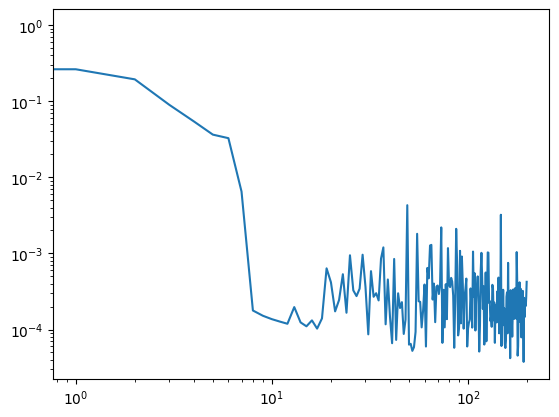

torch.Size([40])


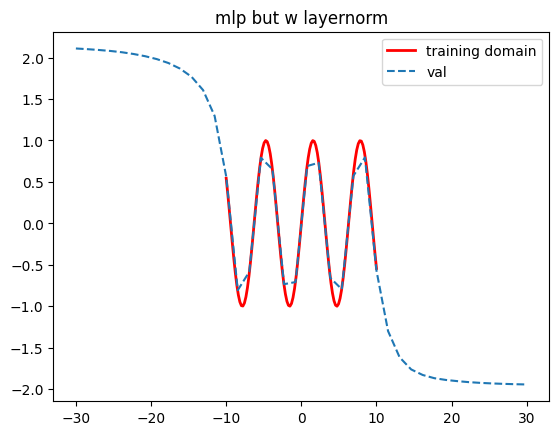

my_transformer(
  (embed): Linear(in_features=1, out_features=64, bias=True)
  (layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transform): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Drop

In [167]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(nn.Linear(1,64),nn.ReLU(),nn.LayerNorm(64), nn.Linear(64,64),nn.ReLU(), nn.LayerNorm(64), nn.Linear(64,1))

    def forward(self,x):
        return self.mlp(x)

my_mlp = MLP()

optim = torch.optim.AdamW(my_mlp.parameters(), lr=5e-4)

loss_list=[]

the_model.train()
for epochs in range(20000):
    
    losss=0
    for X_batch, Y_batch in train_loader:
        output = my_mlp(X_batch)
        loss = loss_fn(output,Y_batch)
        loss.backward()
        optim.step()
        losss+= loss
        optim.zero_grad()
    
    if epochs%100==0:
       # print(losss)
        loss_list.append(loss.detach())


plt.plot(loss_list)  
plt.xscale("log")
plt.yscale("log")
plt.show()  

my_mlp.eval()
thing_to_test_on = torch.linspace(-30,30, 40)
print(thing_to_test_on.shape)
plt.plot(x.squeeze(),y.squeeze(),c="red", linewidth="2", label="training domain")
#plt.plot(x.squeeze(), the_model(x).squeeze().detach(), linestyle="dashed", label="val"  )

plt.plot(thing_to_test_on.squeeze(), my_mlp(thing_to_test_on.unsqueeze(1).unsqueeze(1)).squeeze().detach(), linestyle="dashed", label="val"  )
plt.title("mlp but w layernorm")
plt.legend()
plt.show()

print(the_model)

In [ ]:
#anyway in my experiment here, the layernorm stuff clearly just makes the model learn the data worse (extrapolation sucks both with and without, pick ur poison)
# anyway this is clearly bc layernorm basically normalizes all the features, and if u go outside the domain, u just get bigger features but the std is bigger too so u just get the output normalized all the time

# heres the key: the biases bcome negligible far from center. so inputting x=20 and x=30 are basically the same ater the layernorm cuz u just basically new_activation= 2*old_one, the biases are negligible
# so it literally becomes the same after normalization

torch.Size([1600, 1, 2])


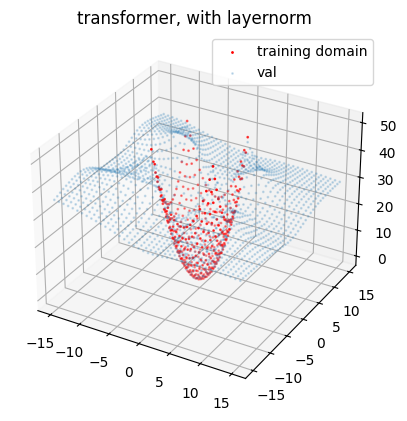

tensor([[20.0831]])


In [ ]:
# so anyway then i predict that if we feed in 2D input, we shud get a plane out outside of the training domain

x = torch.linspace(-5,5,20)
x,y=torch.meshgrid(x,x)
input= torch.vstack( [x.flatten(), y.flatten()] ).T.unsqueeze(1)
output =  (x.flatten()**2 + y.flatten()**2).unsqueeze(1).unsqueeze(1) 

dataset = torch.utils.data.TensorDataset(input,output)
train_loader= torch.utils.data.DataLoader(dataset,batch_size=16)

print(output.shape)
print(max(output))


class Karl_Transformer(nn.Module):
    def __init__(self, input_d=2,output_d=1,hidden_d=16):
        super().__init__()
        self.embed = nn.Linear(input_d,hidden_d)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_d,num_heads=1, batch_first=True)
        self.ffn = nn.Sequential(nn.Linear(hidden_d,4*hidden_d), nn.ReLU(), nn.Linear(4*hidden_d, hidden_d))
        self.unembed = nn.Linear(hidden_d, output_d)
        self.layernorm = nn.LayerNorm(hidden_d)

    def forward(self, x):
        x = self.embed(x)
        x = self.layernorm(x + self.attn(x,x,x)[0]) #turns out nn.MultiheadAttention results results, weights
        x = self.layernorm(x + self.ffn(x))
        x = self.unembed(x)
        return x
    


my_transformer = Karl_Transformer()
loss_fn=nn.MSELoss()
optim = torch.optim.AdamW(my_transformer.parameters(), lr=7e-4)

loss_list=[]

my_transformer.train()
for epochs in range(2000):
    
    losss=0
    for X_batch, Y_batch in train_loader:
        outputt = my_transformer(X_batch)
        loss = loss_fn(outputt,Y_batch)
        loss.backward()
        optim.step()
        losss+= loss
        optim.zero_grad()
    
    if epochs%20==0:
       # print(losss)
        loss_list.append(loss.detach())


plt.plot(loss_list)  
plt.xscale("log")
plt.yscale("log")
plt.show()  

whatevs=15

my_transformer.eval()
thing_1,thing_2 = torch.meshgrid(   torch.linspace(-whatevs,whatevs, 40)  , torch.linspace(-whatevs,whatevs, 40)       )
thing_to_test_on = torch.vstack( [thing_1.flatten(), thing_2.flatten()] ).T.unsqueeze(1)
print(thing_to_test_on.shape)

fig=plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(input[:,0,0], input[:,0,1], output.squeeze() , c="red",  label="training domain", s=1)
#ax.plot(x.squeeze(), the_model(x).squeeze().detach(), linestyle="dashed", label="val"  )

ax.scatter(thing_to_test_on[:,0,0], thing_to_test_on[:,0,1], my_transformer(thing_to_test_on).squeeze().detach(), label="val", alpha=.2,s=1 )
plt.title("transformer, with layernorm")
plt.legend()
plt.show()

print(output[30])



In [ ]:
# so anyway, we get 4 planes. each relu will be on or off and so u just get a matrix linear mapping. 
#with layernorm i assume for same reason as above (input for an r, theta is the same as u scale r), ull just get something like a black hole (except flat in center obvi)